In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lastly/collect_preprocessed_dataset.csv


In [2]:
!pip install transformers==4.45.0 datasets==2.20.0 sentencepiece --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 83.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
s3fs 2025.3.0 requires fsspec==2025.3.0.*, but you have fsspec 2024.5.0 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 wh

In [3]:
import os, warnings
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"
warnings.filterwarnings("ignore")


In [4]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


2025-12-20 07:49:04.490809: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766216944.706255      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766216944.766612      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [5]:
emotion_cols = ['Love','Joy','Anger','Surprise','Sadness','Fear','Hate']

df = pd.read_csv("/kaggle/input/lastly/collect_preprocessed_dataset.csv")

# Keep only necessary columns
df = df[['Data'] + emotion_cols]
df["Data"] = df["Data"].astype(str)

# Convert labels to float32 for multi-label classification
df[emotion_cols] = df[emotion_cols].astype("float32")
df["labels"] = df[emotion_cols].values.tolist()


In [6]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.15, random_state=42, shuffle=True)


In [7]:
train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)


In [8]:
MODEL_NAME = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(
        batch["Data"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/23637 [00:00<?, ? examples/s]

Map:   0%|          | 0/4172 [00:00<?, ? examples/s]

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=7,
    problem_type="multi_label_classification"
)


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = (sigmoid(logits) > 0.5).astype(np.int32)
    labels = labels.astype(np.int32)

    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="macro", zero_division=0)
    rec = recall_score(labels, preds, average="macro", zero_division=0)
    f1 = f1_score(labels, preds, average="macro", zero_division=0)

    return {
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1
    }


In [11]:
training_args = TrainingArguments(
    output_dir="/kaggle/working/xlmroberta-emotion",
    evaluation_strategy="epoch",
    save_strategy="no",           # DO NOT save checkpoints per epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_strategy="epoch",     # logs metrics every epoch
    report_to="none"
)


In [12]:
training_args = TrainingArguments(
    output_dir="/kaggle/working/xlmroberta-emotion",
    evaluation_strategy="epoch",
    logging_strategy="epoch",      # log metrics every epoch
    save_strategy="no",            # disk-safe
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to="none"
)


In [13]:
from transformers import TrainerCallback

class MetricsLoggerCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            print(f"Epoch {state.epoch}:")
            print({k: v for k, v in logs.items() if k not in ['step', 'epoch']})


In [14]:
remove_cols = ['Data'] + emotion_cols

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds.remove_columns(remove_cols),
    eval_dataset=val_ds.remove_columns(remove_cols),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[MetricsLoggerCallback]
)

In [15]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.374000,0.309162,0.289310,0.655889,0.295833,0.364262
2,0.298600,0.286763,0.428332,0.668627,0.463791,0.531411
3,0.255300,0.257878,0.494966,0.693206,0.570080,0.620182
4,0.221900,0.256368,0.540748,0.689632,0.598143,0.634793
5,0.194500,0.240961,0.558245,0.710813,0.625572,0.664090
6,0.169400,0.254535,0.571189,0.704650,0.630450,0.659515
7,0.148600,0.249456,0.611457,0.721228,0.665505,0.690777
8,0.128600,0.260212,0.614813,0.711089,0.674385,0.690938
9,0.112700,0.278051,0.609060,0.706577,0.673332,0.686921
10,0.096400,0.284054,0.623682,0.712420,0.687385,0.698768


TrainOutput(global_step=29560, training_loss=0.12477188678168476, metrics={'train_runtime': 15439.4298, 'train_samples_per_second': 30.619, 'train_steps_per_second': 1.915, 'total_flos': 3.1097176060032e+16, 'train_loss': 0.12477188678168476, 'epoch': 20.0})

In [16]:
predictions = trainer.predict(val_ds.remove_columns(remove_cols))
logits = predictions.predictions
labels = predictions.label_ids


In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

probs = sigmoid(logits)

THRESHOLD = 0.5   # later you can tune per emotion
preds = (probs > THRESHOLD).astype(int)


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

emotion_metrics = {}

for i, emotion in enumerate(emotion_cols):
    y_true = labels[:, i]
    y_pred = preds[:, i]

    emotion_metrics[emotion] = {
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "accuracy": accuracy_score(y_true, y_pred)
    }

emotion_metrics


{'Love': {'precision': 0.7723577235772358,
  'recall': 0.7274119448698315,
  'f1': 0.7492113564668771,
  'accuracy': 0.923777564717162},
 'Joy': {'precision': 0.6304985337243402,
  'recall': 0.654490106544901,
  'f1': 0.6422703510082151,
  'accuracy': 0.8851869606903164},
 'Anger': {'precision': 0.6003184713375797,
  'recall': 0.5854037267080745,
  'f1': 0.5927672955974842,
  'accuracy': 0.8758389261744967},
 'Surprise': {'precision': 0.8360655737704918,
  'recall': 0.826580226904376,
  'f1': 0.8312958435207825,
  'accuracy': 0.9503835091083414},
 'Sadness': {'precision': 0.5923664122137404,
  'recall': 0.6466666666666666,
  'f1': 0.6183266932270914,
  'accuracy': 0.8851869606903164},
 'Fear': {'precision': 0.7792378449408672,
  'recall': 0.8619186046511628,
  'f1': 0.8184955141476881,
  'accuracy': 0.9369606903163951},
 'Hate': {'precision': 0.768566493955095,
  'recall': 0.6856702619414484,
  'f1': 0.7247557003257329,
  'accuracy': 0.9189837008628955}}

In [19]:
metrics = {
 'Love': {'precision': 0.7723, 'recall': 0.7274, 'f1': 0.7492, 'accuracy': 0.9238},
 'Joy': {'precision': 0.6305, 'recall': 0.6545, 'f1': 0.6423, 'accuracy': 0.8852},
 'Anger': {'precision': 0.6003, 'recall': 0.5854, 'f1': 0.5928, 'accuracy': 0.8758},
 'Surprise': {'precision': 0.8361, 'recall': 0.8266, 'f1': 0.8313, 'accuracy': 0.9504},
 'Sadness': {'precision': 0.5924, 'recall': 0.6467, 'f1': 0.6183, 'accuracy': 0.8852},
 'Fear': {'precision': 0.7792, 'recall': 0.8619, 'f1': 0.8185, 'accuracy': 0.9370},
 'Hate': {'precision': 0.7686, 'recall': 0.6857, 'f1': 0.7248, 'accuracy': 0.9190}
}


In [21]:
import matplotlib.pyplot as plt
import numpy as np

labels = list(metrics.keys())
precision = [metrics[l]['precision'] for l in labels]
recall    = [metrics[l]['recall'] for l in labels]
f1        = [metrics[l]['f1'] for l in labels]
accuracy  = [metrics[l]['accuracy'] for l in labels]


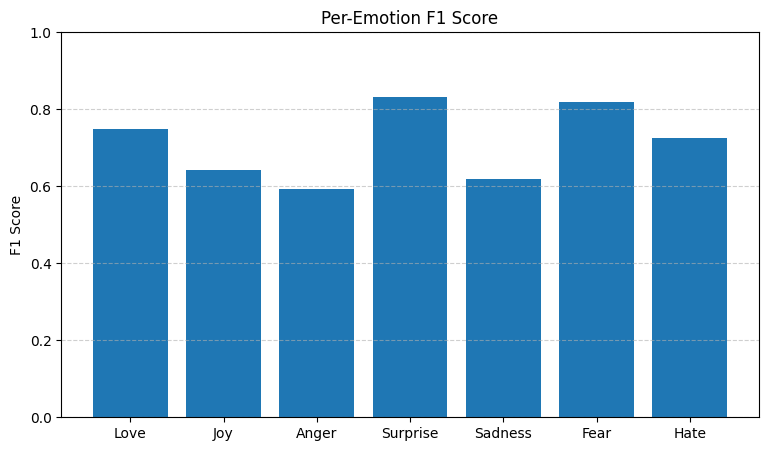

In [22]:
plt.figure(figsize=(9,5))
plt.bar(labels, f1)
plt.title("Per-Emotion F1 Score")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


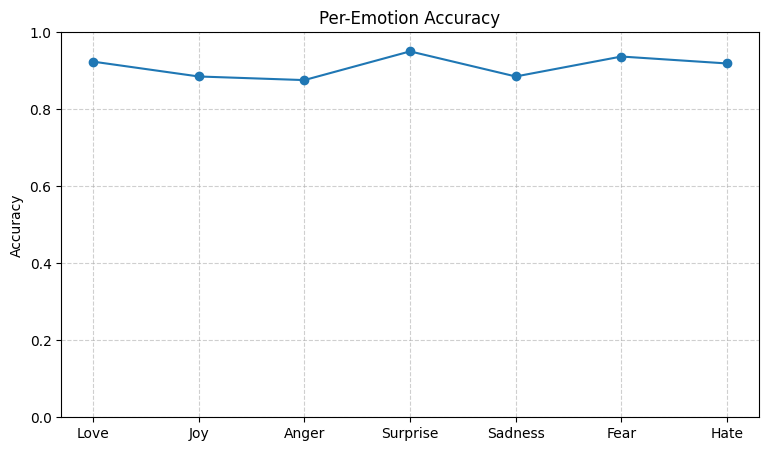

In [31]:
plt.figure(figsize=(9,5))
plt.plot(labels, accuracy, marker='o')
plt.title("Per-Emotion Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


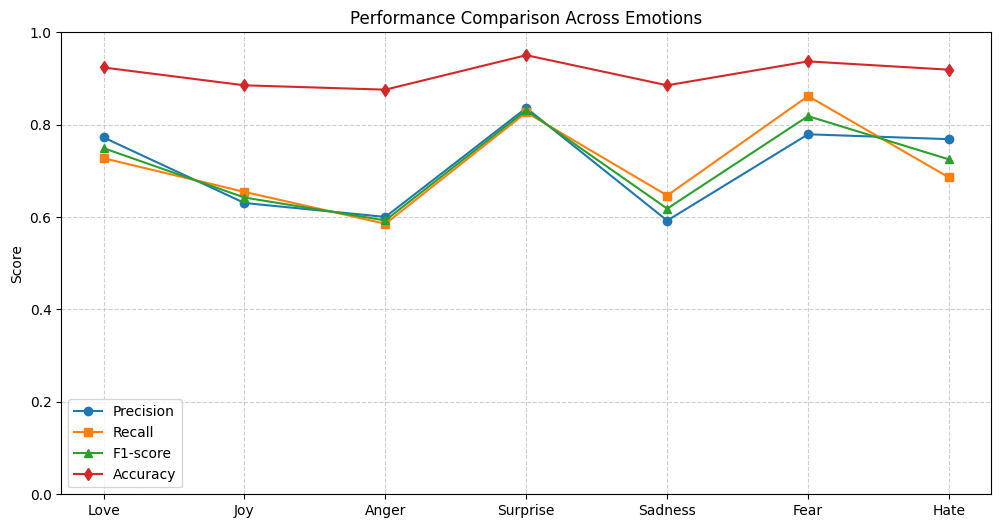

In [23]:
plt.figure(figsize=(12,6))
plt.plot(labels, precision, marker='o', label='Precision')
plt.plot(labels, recall, marker='s', label='Recall')
plt.plot(labels, f1, marker='^', label='F1-score')
plt.plot(labels, accuracy, marker='d', label='Accuracy')

plt.title("Performance Comparison Across Emotions")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


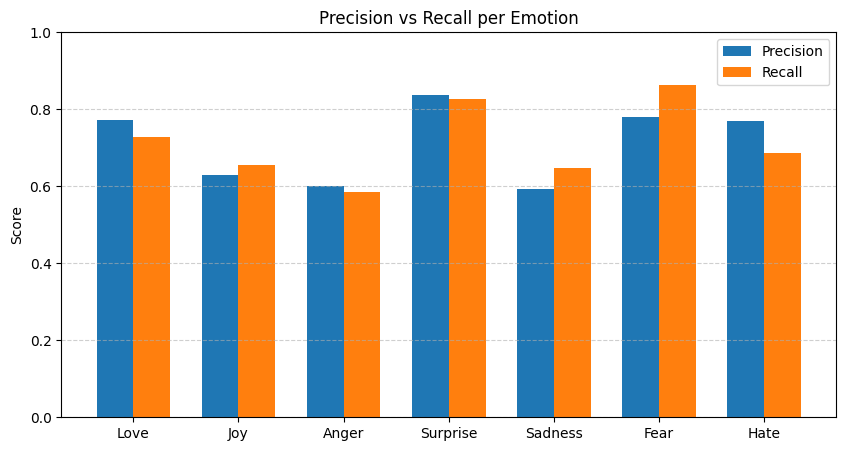

In [32]:
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, precision, width, label='Precision')
plt.bar(x + width/2, recall, width, label='Recall')

plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("Precision vs Recall per Emotion")
plt.legend()
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [33]:
SAVE_PATH = "/kaggle/working/xlmroberta_emotion_model"

trainer.save_model(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)


('/kaggle/working/xlmroberta_emotion_model/tokenizer_config.json',
 '/kaggle/working/xlmroberta_emotion_model/special_tokens_map.json',
 '/kaggle/working/xlmroberta_emotion_model/sentencepiece.bpe.model',
 '/kaggle/working/xlmroberta_emotion_model/added_tokens.json',
 '/kaggle/working/xlmroberta_emotion_model/tokenizer.json')

In [34]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModelForSequenceClassification.from_pretrained(SAVE_PATH).to(device)
tokenizer = AutoTokenizer.from_pretrained(SAVE_PATH)

def predict_emotion(text, threshold=0.5):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    results = [
        (emotion_cols[i], float(probs[i]))
        for i in range(len(emotion_cols))
        if probs[i] >= threshold
    ]

    return sorted(results, key=lambda x: x[1], reverse=True)


In [37]:
predict_emotion("amar mathay onek bhoy lagche")


[('Fear', 0.9984222650527954)]

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

emotion_cols = ['Love','Joy','Anger','Surprise','Sadness','Fear','Hate']

def plot_multilabel_confusion(y_true, y_pred):
    for i, emo in enumerate(emotion_cols):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        
        plt.figure(figsize=(4,3))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Not "+emo, emo],
            yticklabels=["Not "+emo, emo]
        )
        plt.title(f"Confusion Matrix – {emo}")
        plt.ylabel("True")
        plt.xlabel("Predicted")
        plt.show()
